<strong> Import all libraires that will be used </strong>

In [1]:
from utils import PaintingsDataset, AttentionUNetDiscriminator, AttentionUNetGenerator, unet_d_criterion_without_cutmix
import os
import random
import torch
from torch.utils.data import DataLoader
from torchmetrics.image.fid import FrechetInceptionDistance
import torch.optim as optim
from torchvision import transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

<strong> Initializing the paintings dataset </strong>

In [2]:
# Building the dataset
image_dir = '../../data/anime/images_2'
image_size = 64
f = os.listdir(image_dir)[0]
print(f)
print(os.path.isfile(os.path.join(image_dir, f)))

# Transformations to normalize the data before dataloader
transform = transforms.Compose([
    transforms.Resize((image_size,image_size)), # Standardizing the size of the images
    transforms.ToTensor(), # Transforming to tensor
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) # Normalizing
])


# Initializing the dataset
training_dataset = PaintingsDataset(image_dir, transform, limit=-1)
print(f"Dataset contains {len(training_dataset)} images")

44838_2014.jpg
True
Dataset contains 18767 images


<strong> Sampling an element from the dataset and plotting it </strong>

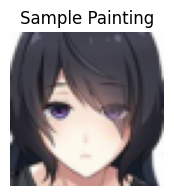

In [3]:
# Sampling randomly an element from the dataset
n = len(training_dataset)
integer = random.randint(0,n)

# Sampled image
image = training_dataset[integer].numpy()*0.5 + 0.5 # De-normalizing the image

# Plot the image
plt.figure(figsize=(3, 2))
plt.imshow(np.transpose(image, (1, 2, 0)))  
plt.axis('off')  # Hide axes
plt.title('Sample Painting')
plt.show()

<strong> Intializing the Dataloader </strong>

In [4]:
batch_size = 64

<strong> Initializing the parameters of the model </strong>

In [5]:
# Model's parameters
latent_dim = 100
channels_out = 3
channels_in = 3

# Intializing the models
G = AttentionUNetGenerator(latent_dim, channels_out)
D = AttentionUNetDiscriminator(3)

<strong> Sampling a vector to plot the fake image generated by the Generator </strong>

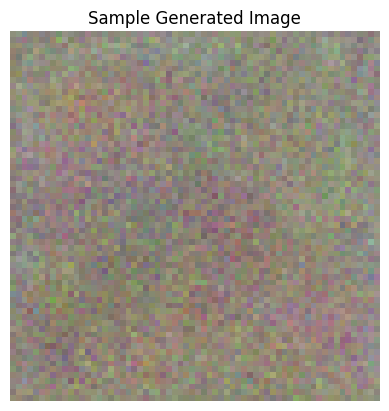

In [6]:
# Generate random noise
latent_dim = 100  # Latent space dimension

# Generate random noise
noise = torch.randn(16, latent_dim, image_size, image_size)  # Noise input for generator
# Generate images
fake_images = G(noise)  # Output shape: [16, 3, 128, 128]

# De-normalize and reshape the first generated image
image_generated = fake_images[0].detach().cpu().numpy()  # Select first image in batch
image_generated = image_generated * 0.5 + 0.5  # De-normalize to [0, 1]

# Plot the image
plt.imshow(np.transpose(image_generated, (1, 2, 0)))  # Convert to (H, W, C)
plt.axis('off')  # Hide axes
plt.title('Sample Generated Image')
plt.show()

<strong> Let build the training loop</strong>

In [7]:
import torch.nn.functional as F
from torchvision.models import resnet18, ResNet18_Weights

def diversity_loss(fake_images, feature_extractor):
    # Extract features using a pretrained model
    features = feature_extractor(fake_images)  # Shape: (batch_size, feature_dim)

    # Normalize features to unit vectors
    features = F.normalize(features, p=2, dim=1)

    # Compute pairwise cosine similarity
    similarity_matrix = torch.matmul(features, features.T)  # Shape: (batch_size, batch_size)

    # Remove diagonal elements (self-similarity)
    batch_size = similarity_matrix.size(0)
    mask = torch.eye(batch_size, device=similarity_matrix.device).bool()
    diversity_penalty = similarity_matrix.masked_fill(mask, 0).mean()

    return diversity_penalty

In [8]:
def gradient_penalty(D, real, fake,device='cuda'):
    # Compute random weight for interpolation
    alpha = torch.rand(real.size(0), 1, 1, 1).to(device)

    # Interpolate real and fake images
    interpolated = (alpha * real + (1 - alpha) * fake).requires_grad_()

    # Compute output of the critic
    prob_interpolated = D(interpolated)

    # Compute gradients of the critic with respect to the interpolated images
    gradients = torch.autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                                    grad_outputs=torch.ones_like(prob_interpolated),
                                    create_graph=True, retain_graph=True)[0]

    # Compute gradient penalty
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(p=2, dim=1) - 1) ** 2).mean()

    return gradient_penalty


In [9]:

torch.autograd.set_detect_anomaly(True)

loss_options = ["w","bce"]
loss_option = loss_options[0]

image_size = 64
experiment = 3

output_dir = f"training_samples/experiment_{experiment}"
os.makedirs(output_dir, exist_ok=True)

# Parameters
input_channels = 3
channels_out = input_channels
n_classes = 2
k = 5  # number of critic updates per generator update
latent_dim = 256
training_steps = 50000 # Number of training steps
lambda_gp = 10  # Gradient penalty weight
lambda_div = 5  # Diversity loss weight

d_lr = 1e-4 if loss_option == "w" else 2e-4  # Base learning rate
g_lr = 2e-4 if loss_option == "w" else 2e-4  # Base learning rate


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# feature extractor to compute diversity loss
feature_extractor = resnet18(weights=ResNet18_Weights.DEFAULT)
feature_extractor.eval().to(device)

# Initialize models (Use Attention U-Net GAN models)
G_attention = AttentionUNetGenerator(latent_dim, channels_out).to(device)  # Latent space maps to input

if loss_option == "w":
    D_attention = AttentionUNetDiscriminator(input_channels, features=64, use_sigmoid=False).to(device)  # Wasserstein discriminator
elif loss_option == "bce":
    D_attention = AttentionUNetDiscriminator(input_channels, features=64).to(device)  # PatchGAN discriminator

# Loss function and optimizers
if loss_option == "bce":
    criterion = torch.nn.BCELoss()  # Binary Cross-Entropy for GANs

optimizer_g = torch.optim.Adam(G_attention.parameters(), lr=g_lr, betas=(0.0, 0.9) if loss_option == "w" else (0.5, 0.999))
optimizer_d = torch.optim.Adam(D_attention.parameters(), lr=d_lr, betas=(0.0, 0.9) if loss_option == "w" else (0.5, 0.999))

# FID Evaluation setup
epoch_eval = training_steps // 1000 # Print losses every `epoch_eval` epochs
epoch_fid = training_steps // 20  # Evaluate FID every `epoch_eval` epochs
epoch_sampling = training_steps // 200 # Save generated samples every `epoch_sampling` epochs


fid = FrechetInceptionDistance(feature=192, reset_real_features=False, normalize=True)
n_samples = 1000

# Ensure your dataset of real paintings is available
N = len(training_dataset)  # Assuming `paintings` is a tensor of real images
indices = random.sample(range(N), n_samples)
real_images_eval = torch.stack([training_dataset[idx] for idx in indices])
fid.update(real_images_eval, real=True)

# Track losses and FID values
FID_values = []
D_loss = []
G_loss = []

data_iter = training_dataset.get_infinite_iterator(batch_size)
# Training loop
start_time = time.time()
for step in tqdm(range(training_steps)):

    # Turn dataloader into an iterator for this epoch
    
    ################################################################
    # 1) CRITIC (DISCRIMINATOR) UPDATES — do k iterations
    ################################################################
    for _ in range(k):
        # Get next batch of real images
        real_images = next(data_iter).to(device)

        # Possibly create BCE labels if using BCE
        if loss_option == "bce":
            batch_size = real_images.size(0)
            labels_real = torch.full((batch_size, 1), 0.9, device=device)
            labels_fake = torch.full((batch_size, 1), 0.1, device=device)

        # Zero grad for D
        optimizer_d.zero_grad()

        # Optionally add small noise to real images
        real_noisy = real_images + torch.randn_like(real_images) * 0.01

        # ----- 1(a): Discriminator loss on real
        if loss_option == "w":
            output_real = D_attention(real_noisy).view(-1)
            loss_d_real = -output_real.mean()
        else:  # BCE
            output_real = D_attention(real_noisy).view(-1, 1)
            loss_d_real = criterion(output_real, labels_real)

        # ----- 1(b): Discriminator loss on fake
        noise = torch.randn(real_images.size(0), latent_dim, image_size, image_size, device=device)
        fake_images = G_attention(noise).detach()  # detach so G is not updated here

        fake_noisy = fake_images + torch.randn_like(fake_images) * 0.01

        if loss_option == "w":
            output_fake = D_attention(fake_noisy).view(-1)
            loss_d_fake = output_fake.mean()
        else:  # BCE
            output_fake = D_attention(fake_noisy).view(-1, 1)
            loss_d_fake = criterion(output_fake, labels_fake)

        # ----- 1(c): Gradient Penalty
        gp = gradient_penalty(D_attention, real_noisy, fake_noisy, device=device) 
        # gradient_penalty(...) is assumed to return scalar

        # Combine D losses
        loss_d = loss_d_real + loss_d_fake + lambda_gp * gp
        
        # Backprop and step
        loss_d.backward()
        optimizer_d.step()

    # The for-loop completed *without* hitting StopIteration
    # => Now do the Generator update

    ################################################################
    # 2) GENERATOR UPDATE — 1 iteration
    ################################################################
    for p in D_attention.parameters():
        p.requires_grad = False

    # We'll generate a new batch of noise/images
    # You could match real_images.size(0) if you like:
    noise = torch.randn(real_images.size(0), latent_dim, image_size, image_size, device=device)
    fake_images = G_attention(noise)
    
    # Zero grad for G
    optimizer_g.zero_grad()

    if loss_option == "w":
        output_fake_for_gen = D_attention(fake_images).view(-1)
        loss_g = -output_fake_for_gen.mean()
    else:  # BCE
        # Reuse the "labels_real" notion: G wants D(fake) ~ 1
        # but we need batch_size again
        batch_size = real_images.size(0)
        labels_real = torch.full((batch_size, 1), 0.9, device=device)
        output_fake_for_gen = D_attention(fake_images).view(-1, 1)
        loss_g = criterion(output_fake_for_gen, labels_real)

    # Diversity penalty (optional)
    diversity_pen = diversity_loss(fake_images, feature_extractor)
    loss_g += lambda_div * diversity_pen

    # Backprop and step
    loss_g.backward()
    optimizer_g.step()

    # Re-enable D grads for next iteration
    for p in D_attention.parameters():
        p.requires_grad = True


    # Evaluate FID every `epoch_eval` epochs
    if step % epoch_fid == 0:
        G_attention.eval()  # Set generator to eval mode for FID computation
        fake_images_eval = []
        with torch.no_grad():
        # Generate evaluation images
            noise_eval = torch.randn(n_samples, latent_dim, image_size, image_size, device=device)
            for i in range(0, n_samples, batch_size):
                fake_images_chunk = G_attention(noise_eval[i:i+batch_size]).to('cpu')
                fid.update(fake_images_chunk, real=False)
                fake_images_eval.append(fake_images_chunk)

            fid_value = fid.compute().item()
            FID_values.append(fid_value)

            print(f'FID after step {step}: {fid_value}')

        # Save a grid of generated samples
        fake_images_eval = torch.cat(fake_images_eval, dim=0)
        grid = vutils.make_grid(fake_images_eval[:64], normalize=True, scale_each=True)
        sample_path = os.path.join(output_dir, f"step_{step:03d}.png")
        vutils.save_image(grid, sample_path)
        print(f"Sample images saved to {sample_path}")
        
        del fake_images_eval
        torch.cuda.empty_cache()
        fid.reset()
        G_attention.train()
        
    elif step % epoch_sampling == 0:
        G_attention.eval()  # Set generator to eval mode for FID computation
        
        # Generate evaluation images
        with torch.no_grad():
            noise_eval = torch.randn(64, latent_dim, image_size, image_size, device=device)
            fake_images_eval = G_attention(noise_eval).to(torch.device('cpu'))
        
        # Save a grid of generated samples
        grid = vutils.make_grid(fake_images_eval, normalize=True, scale_each=True)
        sample_path = os.path.join(output_dir, f"step_{step:03d}.png")
        vutils.save_image(grid, sample_path)
        print(f"Sample images saved to {sample_path}")
        
        del fake_images_eval
        torch.cuda.empty_cache()
        G_attention.train()
        
        # Track losses
        D_loss.append(loss_d.item())
        G_loss.append(loss_g.item())

    if step % epoch_eval == 0:
        end_time = time.time()
        
        print(f'Epoch [{step }/{training_steps}] | Loss D: {loss_d.item()} | Loss G: {loss_g.item()} | Diversity Loss: {lambda_div*diversity_pen.item()} | Gradient Penalty: {lambda_gp*gp.item()} | Wasserstein Distance: { - loss_d_real.item() - loss_d_fake.item()}')
        print(f'Epoch duration: {end_time - start_time:.2f}s')
        start_time = time.time()


cuda


  0%|          | 0/200000 [00:00<?, ?it/s]

FID after step 0: 296.4175720214844
Sample images saved to training_samples/experiment_3\step_000.png
Epoch [0/200000] | Loss D: 5.671615123748779 | Loss G: 4.302303791046143 | Diversity Loss: 4.604957103729248 | Gradient Penalty: 7.876183986663818 | Wasserstein Distance: 2.2045689821243286
Epoch duration: 23.02s
Epoch [200/200000] | Loss D: -12.309738159179688 | Loss G: -2.6104602813720703 | Diversity Loss: 2.174037992954254 | Gradient Penalty: 0.7821856439113617 | Wasserstein Distance: 13.091923356056213
Epoch duration: 240.17s
Epoch [400/200000] | Loss D: -5.955638408660889 | Loss G: 0.9592870473861694 | Diversity Loss: 1.0451246798038483 | Gradient Penalty: 2.3134714365005493 | Wasserstein Distance: 8.269109725952148
Epoch duration: 218.80s
Epoch [600/200000] | Loss D: -5.452637195587158 | Loss G: -10.626981735229492 | Diversity Loss: 1.037774235010147 | Gradient Penalty: 0.3874613344669342 | Wasserstein Distance: 5.8400983810424805
Epoch duration: 211.79s
Epoch [800/200000] | Loss

KeyboardInterrupt: 

In [10]:
torch.save(D_attention.state_dict(), f"weights/d_att_{experiment}.pth")
torch.save(G_attention.state_dict(), f"weights/g_att_{experiment}.pth")

<strong> Generating some examples using the trained generator </strong>

torch.Size([1, 3, 64, 64])


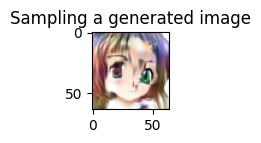

In [ ]:
# Generate random noise
noise = torch.randn(1, latent_dim, image_size, image_size)  # Batch of 16 noise vectors

G_unet_test = G_attention.to('cpu')
# Generate images
fake_images = G_unet_test(noise)

print(fake_images.size())  # Should be (16, img_channels, height, width)

image_noise = fake_images.detach().numpy().reshape((3,image_size,image_size))*0.5 + 0.5

plt.figure(figsize=(2, 1))
plt.imshow(np.transpose(image_noise, (1, 2, 0)))
plt.title("Sampling a generated image")
plt.show()

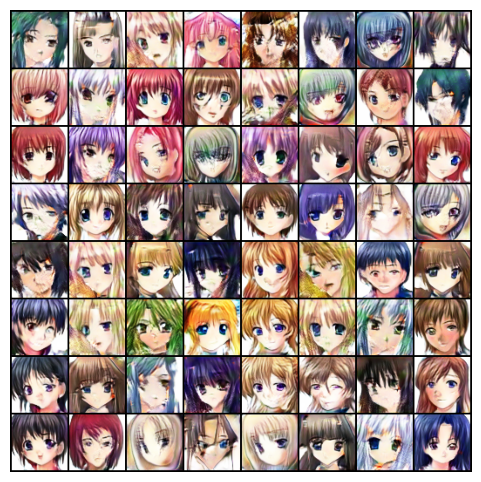

In [50]:
noise_eval = torch.randn(64, latent_dim, image_size, image_size, device=torch.device('cpu'))
fake_images_eval = G_attention(noise_eval).to(torch.device('cpu'))

# Save a grid of generated samples
grid = vutils.make_grid(fake_images_eval, normalize=True, scale_each=True)
np_grid = grid.permute(1, 2, 0).numpy()

# Display the images
plt.figure(figsize=(8, 8))
plt.imshow(np_grid)
plt.axis('off')  # Turn off axis
plt.show()

<strong> Plotting Losses <strong>

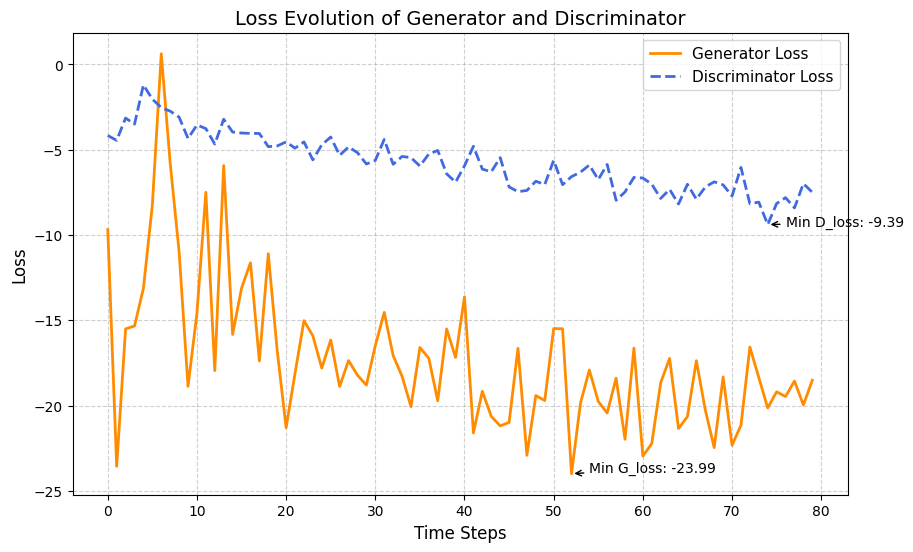

In [ ]:
# Assuming G_loss and D_loss are defined
ng = len(G_loss)
nd = len(D_loss)
time_steps_g = [i for i in range(ng)]
time_steps_d = [i for i in range(nd)]


plt.figure(figsize=(10, 6))

# Plot Generator Loss
plt.plot(time_steps_g, G_loss, label='Generator Loss', color='darkorange', linestyle='-', linewidth=2)

# Plot Discriminator Loss
plt.plot(time_steps_d, D_loss, label='Discriminator Loss', color='royalblue', linestyle='--', linewidth=2)

# Add grid, labels, and title
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Evolution of Generator and Discriminator', fontsize=14)

# Adding legend
plt.legend(loc='upper right', fontsize=11)

# Adding annotations for minimum loss points (optional)
min_G_loss = min(G_loss)
min_G_loss_idx = G_loss.index(min_G_loss)
plt.annotate(f'Min G_loss: {min_G_loss:.2f}', xy=(min_G_loss_idx, min_G_loss),
             xytext=(min_G_loss_idx + n*0.1, min_G_loss + max(G_loss)*0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

min_D_loss = min(D_loss)
min_D_loss_idx = D_loss.index(min_D_loss)
plt.annotate(f'Min D_loss: {min_D_loss:.2f}', xy=(min_D_loss_idx, min_D_loss),
             xytext=(min_D_loss_idx + n*0.1, min_D_loss + max(D_loss)*0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

# Show plot
plt.show()

<strong> Plotting FID values <strong>

Text(0.5, 1.0, 'FID Evolution through training')

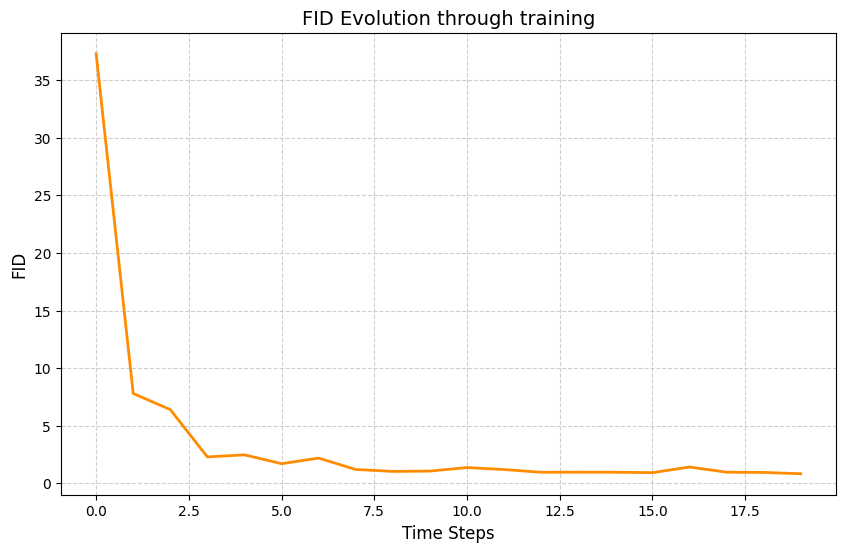

In [13]:
n = len(FID_values)
time_steps = [i for i in range(n)]

plt.figure(figsize=(10, 6))

# Plot FID values
plt.plot(time_steps, FID_values, label='Generator FID', color='darkorange', linestyle='-', linewidth=2)


# Add grid, labels, and title
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('FID', fontsize=12)
plt.title('FID Evolution through training', fontsize=14)

In [14]:
# Save G_loss and D_loss to text files
np.savetxt(f'plots/g_loss_{experiment}.txt', np.array(G_loss))
np.savetxt(f'plots/d_loss_{experiment}.txt', np.array(D_loss))

# Load G_loss and D_loss from text files
loaded_g_loss = np.loadtxt(f'plots/g_loss_{experiment}.txt')
loaded_d_loss = np.loadtxt(f'plots/d_loss_{experiment}.txt')

In [15]:
# Save FID values to a text file
np.savetxt(f'plots/fid_values_{experiment}.txt', np.array(FID_values))

# Load FID values from a text file
loaded_fid_values = np.loadtxt(f'plots/fid_values_{experiment}.txt')
print(loaded_fid_values)

[37.29192734  7.79943132  6.39948893  2.29505491  2.47268558  1.70718801
  2.19171     1.20318317  1.03526342  1.06450415  1.3687607   1.19921172
  0.96061331  0.97028887  0.96526223  0.92675114  1.41838992  0.9690119
  0.94587034  0.83528078]
